In [18]:
import torch
import torch.nn as nn
import torchsummary
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
sns.set_style('darkgrid')

In [28]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), # AlexNet espera imagens de 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

len(train_dataset), len(test_dataset)

(60000, 10000)

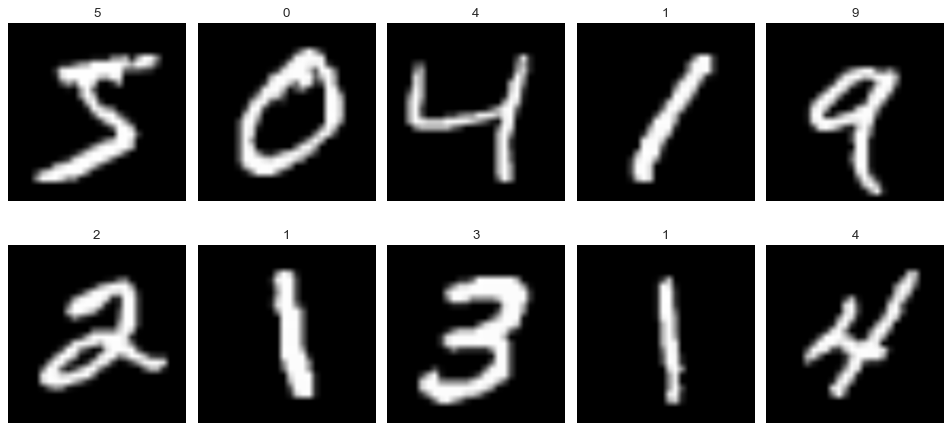

In [17]:
plt.figure(figsize=(12, 6), dpi=80)

for i in range(10):
    plt.subplot(2, 5, i + 1)
    img, label = train_dataset[i]
    plt.imshow(img.squeeze().numpy(), cmap='gray')
    plt.title(label)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

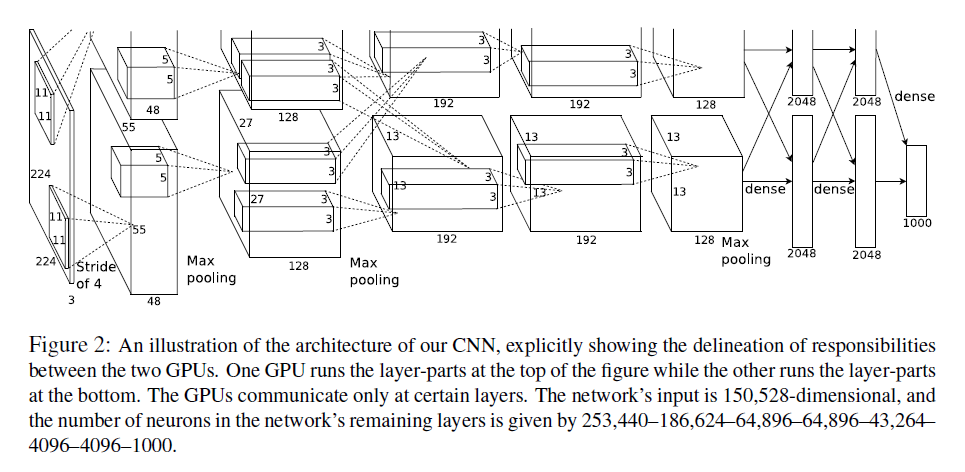

In [24]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            # Capa 1: Convolucional
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=2), # Entrada: 224x224x3, salida: 55x55x96
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2), # Entrada: 55x55x96, salida: 27x27x96
            
            # Capa 2: Convolucional
            nn.Conv2d(96, 256, kernel_size=5, padding=2), # Entrada: 27x27x96, salida: 27x27x256
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2), # Entrada: 27x27x256, salida: 13x13x256
            
            # Capa 3: Convolucional
            nn.Conv2d(256, 384, kernel_size=3, padding=1), # Entrada: 13x13x256, salida: 13x13x384
            nn.ReLU(inplace=True),
            
            # Capa 4: Convolucional
            nn.Conv2d(384, 384, kernel_size=3, padding=1), # Entrada: 13x13x384, salida: 13x13x384
            nn.ReLU(inplace=True),
            
            # Capa 5: Convolucional
            nn.Conv2d(384, 256, kernel_size=3, padding=1), # Entrada: 13x13x384, salida: 13x13x256
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2) # Entrada: 13x13x256, salida: 6x6x256
        )
        self.classifier = nn.Sequential(
            # Capa 6: Totalmente Conectada
            nn.Linear(256 * 6 * 6, 4096), # Entrada: 6x6x256, salida: 4096
            nn.ReLU(inplace=True),
            nn.Dropout(),
            
            # Capa 7: Totalmente Conectada
            nn.Linear(4096, 4096), # Entrada: 4096, salida: 4096
            nn.ReLU(inplace=True),
            nn.Dropout(),
            
            # Capa 8: Totalmente Conectada
            nn.Linear(4096, num_classes) # Entrada: 4096, salida: num_classes
        )
        
    def forward(self, x):
        x = self.features(x) # Aplicar capas convolucionales
        x = torch.flatten(x, 1) # Aplanar tensores
        x = self.classifier(x)
        return x
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AlexNet(num_classes=len(train_dataset.classes)).to(device)
torchsummary.summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          11,712
              ReLU-2           [-1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

In [29]:
import torchmetrics

criteron = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
acc = torchmetrics.classification.Accuracy(task='multiclass', num_classes=len(train_dataset.classes))

In [30]:
from tqdm import tqdm

num_epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0
    test_loss = 0.0
    test_accuracy = 0.0
    
    for i, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training")):
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criteron(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_accuracy += acc(outputs, labels)
    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)
    
    with torch.no_grad():
        model.eval()
        for i, (images, labels) in enumerate(tqdm(test_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Testing")):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criteron(outputs, labels)
            
            test_loss += loss.item()
            test_accuracy += acc(outputs, labels)
        test_loss /= len(test_loader)
        test_accuracy /= len(test_loader)
        
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch 1/10 - Training:  38%|███▊      | 712/1875 [27:06<44:16,  2.28s/it]  


KeyboardInterrupt: 